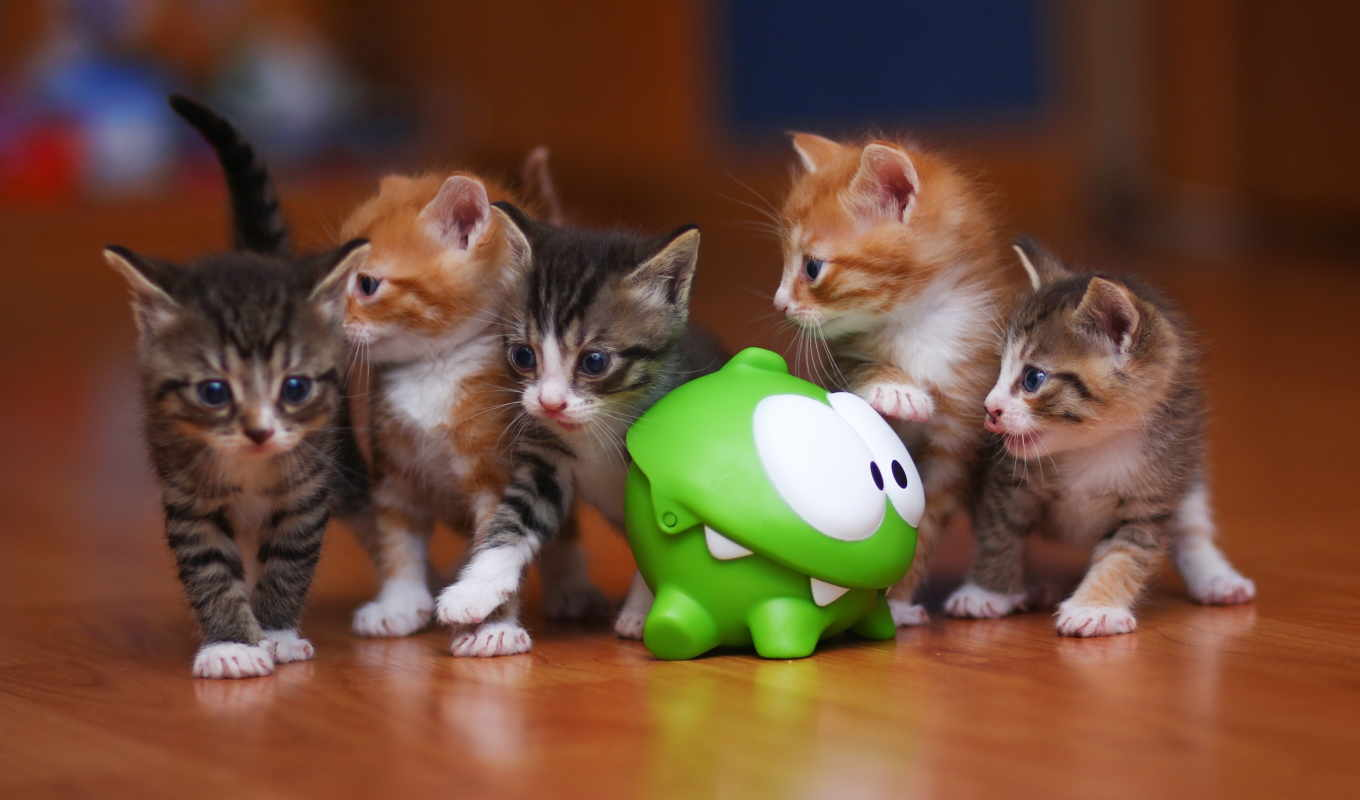

# RuCoS

---



## Loading data

In [ ]:
!wget https://onti2020.ai-academy.ru/task/rucos_test.jsonl #test

In [ ]:
!wget https://onti2020.ai-academy.ru/task/rucos_train.jsonl.zip #train.zip

In [ ]:
!wget https://onti2020.ai-academy.ru/task/rucos_val.jsonl #val

In [ ]:
!unzip rucos_train.jsonl.zip #unzip train

In [ ]:
import os                                                       #
os.rename('rucos_test.jsonl','test.jsonl')                      # Rename files
os.rename('rucos_train.jsonl','train.jsonl')                    #
os.rename('rucos_val.jsonl','val.jsonl')                        #

## Libraries

In [ ]:
# !pip install ipywidgets                                                       # for cristofari supercomputer
# !jupyter nbextension enable --py widgetsnbextension                           #

In [ ]:
!pip install transformers
!pip install transformers sentencepiece
!pip install sentencepiece

In [ ]:
!pip install jsonlines

In [ ]:
import pandas as pd
import numpy as np

from collections import Counter
from tqdm import tqdm

import json
import jsonlines

import re

## Load models

In [ ]:
from transformers import AutoModelForQuestionAnswering, AutoTokenizer, pipeline #
                                                                                #        
model_name = "deepset/xlm-roberta-large-squad2"                                 #        
                                                                                # for Question Answering   
qa_model = AutoModelForQuestionAnswering.from_pretrained(model_name)            #    
qa_tokenizer = AutoTokenizer.from_pretrained(model_name)                        #        

In [ ]:
from transformers import AutoModelForSequenceClassification                         #
                                                                                    #
logic_model_name = "amberoad/bert-multilingual-passage-reranking-msmarco"           #
                                                                                    # for Logical Connection        
logic_model = AutoModelForSequenceClassification.from_pretrained(logic_model_name)  #
logic_tokenizer = AutoTokenizer.from_pretrained(logic_model_name)                   #        

## Training QA model

In [ ]:
def jsonl_to_train_df(file_name):
    df = pd.DataFrame(columns=['context', 'question', 'answer'])
    with open(file_name, 'r') as file:
        json_list = list(file)
        for i in tqdm(range(15000)):
            json_str = json.loads(json_list[i])
            text_idx = json_str['idx']
            entities_list = json_str['passage']['entities']
            text = json_str['passage']['text']
            if len(qa_tokenizer.tokenize(text)) <= 512:
                text_hightlight = text[text.find('@highlight'):]
                text_hightlight = text_hightlight.replace('@highlight', ' . ')
                text = text[:text.find('@highlight'):]
                text = text.replace('@header', ' . ')
                text = text.replace('\\n', ' ')
                text = text.replace('\n', ' ')
                text = text.replace('\\', ' ')
                text = text.replace('. .', '. ')
                text = text.replace('.', '. ')
                text = text.replace('.  .', '. ')
                text = text.replace('.   .', '. ')
                text = text.replace('  ', ' ')
                text = text.replace('   ', ' ')
                text = text.replace('    ', ' ')
                text = text.strip()
                text = text[:len(text)-1:] + '. '
                for sent in text_hightlight.split('.'):
                    for j in range(len(entities_list)):
                        ans = json_str['passage']['text'][json_str['passage']['entities'][j]['start']:json_str['passage']['entities'][j]['end']:]
                    if ans in sent:
                        text = text + ' ' + sent + '.'
                        break
                text = text.replace('@header', ' . ')
                text = text.replace('\\n', ' ')
                text = text.replace('\n', ' ')
                text = text.replace('\\', ' ')
                text = text.replace('. .', '. ')
                text = text.replace('.', '. ')
                text = text.replace('.  .', '. ')
                text = text.replace('.   .', '. ')
                text = text.replace('  ', ' ')
                text = text.replace('   ', ' ')
                text = text.replace('    ', ' ')
                text = text.replace(' .', '.')
                text = text.lower()
                mask = json_str['qas'][0]['query']
                mask = mask.lower()
                mask = mask.replace('@placeholder', ' Kто ')
                mask = mask.strip()
                mask = mask[:len(mask)-1:] + '?'
                set_entites = []
                for j in range(len(entities_list)):
                    ans = json_str['passage']['text'][json_str['passage']['entities'][j]['start']:json_str['passage']['entities'][j]['end']:]
                    if not (ans  in set_entites):
                        set_entites.append(ans)
                if 'answers' in json_str['qas'][0].keys():
                    set_true_ans= []
                    for j in range(len(json_str['qas'][0]['answers'])):
                        true_ans = json_str['qas'][0]['answers'][j]['text']
                        if not (true_ans in set_true_ans) and len(true_ans.strip().split(' '))<=1:
                            if text.find(true_ans.lower())!= -1:
                                df.loc[len(df)] = [text, mask, {'answer_start': text.find(true_ans.lower()), 'text':true_ans}]
                                set_true_ans.append(true_ans)
    return df

In [ ]:
train_df = jsonl_to_train_df('train.jsonl')

In [ ]:
train_df.head()

In [ ]:
def read_train_df(df):
    contexts = []
    questions = []
    answers = []
    for i in range(len(df)):
        contexts.append(df.iloc[i].context)
        questions.append(df.iloc[i].question)
        answers.append(df.iloc[i].answer)
    return contexts, questions, answers

train_contexts, train_questions, train_answers = read_train_df(train_df)

In [ ]:
train_answers[-1]

In [ ]:
def add_end_idx(answers, contexts):
    for answer, context in zip(answers, contexts):
        gold_text = answer['text']
        start_idx = answer['answer_start']
        end_idx = start_idx + len(gold_text)

    
        if context[start_idx:end_idx] == gold_text.lower():
            answer['answer_end'] = end_idx
        elif context[start_idx-1:end_idx-1] == gold_text.lower():
            answer['answer_start'] = start_idx - 1
            answer['answer_end'] = end_idx - 1    
        elif context[start_idx-2:end_idx-2] == gold_text.lower():
            answer['answer_start'] = start_idx - 2
            answer['answer_end'] = end_idx - 2     

add_end_idx(train_answers, train_contexts)

In [ ]:
train_answers[-1]

In [ ]:
train_encodings = qa_tokenizer(train_contexts, train_questions, truncation=True, padding=True)

In [ ]:
def add_token_positions(encodings, answers):
    start_positions = []
    end_positions = []
    for i in tqdm(range(len(answers))):
        start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
        end_positions.append(encodings.char_to_token(i, answers[i]['answer_end']))

      
        if start_positions[-1] is None:
            start_positions[-1] = tokenizer.model_max_length


        if end_positions[-1] is None:
            end_positions[-1] = encodings.char_to_token(i, answers[i]['answer_end'] + 1)
    encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

add_token_positions(train_encodings, train_answers)

In [ ]:
import torch

class NewDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

train_dataset = NewDataset(train_encodings)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
device

In [ ]:
qa_model.to(device)

In [ ]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    save_steps=100000,
    learning_rate = 1e-6,
    output_dir='./otputs/results',         
    overwrite_output_dir = True,
    num_train_epochs=2,             
    per_device_train_batch_size=2,  
    warmup_steps=500,               
    weight_decay=0.03,               
)


In [ ]:
trainer = Trainer(
    model=qa_model,                        
    args=training_args,                 
    train_dataset=train_dataset
)

In [ ]:
trainer.train_dataset

In [ ]:
trainer.train() #Cuda!!!

## Models setup

### QA_model

In [ ]:
nlp = pipeline('question-answering', model=qa_model, tokenizer=qa_tokenizer, device=0)

In [ ]:
QA_input = {
    'question': "Наряду с Австрией  кто  имеет самый низкий уровень безработицы в еврозоне ?",
    'context': "2015 год начался для немецкого бизнеса удачно. Население активно тратит деньги, предприятия нанимают новых сотрудников, а эксперты повышают прогнозы роста немецкой экономики. Германия вновь берет на себя функцию экономического локомотива еврозоны. Опубликованные за первые два месяца 2015 года статистические данные, социологические опросы и корпоративные новости свидетельствуют о том, что крупнейшая экономика Европейского валютного союза набирает обороты намного быстрее, чем ожидалось. В результате годовой рост ВВП может составить вполне приличные для высокоразвитой страны 2 процента, что даст серьезный импульс всему Евросоюзу. Немцы охотно тратят деньги Многие годы основной движущей силой немецкой экономики был экспорт, что вело к высокой зависимости бизнеса от состояния дел на внешних рынках."
}

In [ ]:
res = nlp(QA_input)
res

### Logic_model

In [ ]:
logic_model.cuda()

In [ ]:
classes = ["не следует", "следует"]

sequence_0 = '''кто едет по дороге?'''
sequence_1 = '''едет Машина'''

paraphrase = logic_tokenizer(sequence_0, sequence_1, return_tensors="pt").to(device)

paraphrase_classification_logits = logic_model(**paraphrase).logits

paraphrase_results = torch.softmax(paraphrase_classification_logits, dim=1).tolist()[0]



for i in range(len(classes)):
     print(f"{classes[i]}: {int(round(paraphrase_results[i] * 100))}%") #100% and 0%

## Functions

In [ ]:
def jsonl_to_df(file_name):
    df = pd.DataFrame(columns=['idx', 'text', 'question', 'answers'])
    with open(file_name, 'r') as file:
        json_list = list(file)
        for i in tqdm(range(len(json_list))):
            json_str = json.loads(json_list[i])
            text_idx = json_str['idx']
            entities_list = json_str['passage']['entities']
            text = json_str['passage']['text']
            text_hightlight = text[text.find('@highlight'):]
            text_hightlight = text_hightlight.replace('@highlight', ' . ')
            text = text[:text.find('@highlight'):]
            text = text.replace('@header', ' . ')
            text = text.replace('\\n', ' ')
            text = text.replace('\n', ' ')
            text = text.replace('\\', ' ')
            text = text.replace('. .', '. ')
            text = text.replace('.', '. ')
            text = text.replace('.  .', '. ')
            text = text.replace('.   .', '. ')
            text = text.replace('  ', ' ')
            text = text.replace('   ', ' ')
            text = text.replace('    ', ' ')
            text = text.strip()
            text = text[:len(text)-1:] + '. '
            for sent in text_hightlight.split('.'):
                for j in range(len(entities_list)):
                    ans = json_str['passage']['text'][json_str['passage']['entities'][j]['start']:json_str['passage']['entities'][j]['end']:]
                    if ans in sent:
                        text = text + ' ' + sent + '.'
                        break
            text = text.replace('@header', ' . ')
            text = text.replace('\\n', ' ')
            text = text.replace('\n', ' ')
            text = text.replace('\\', ' ')
            text = text.replace('. .', '. ')
            text = text.replace('.', '. ')
            text = text.replace('.  .', '. ')
            text = text.replace('.   .', '. ')
            text = text.replace('  ', ' ')
            text = text.replace('   ', ' ')
            text = text.replace('    ', ' ')
            text = text.replace(' .', '.')
            mask = json_str['qas'][0]['query']
            mask = mask.replace('@placeholder', ' Kто ')
            mask = mask.strip()
            mask = mask[:len(mask)-1:] + '?'
            set_entites = []
            for j in range(len(entities_list)):
                ans = json_str['passage']['text'][json_str['passage']['entities'][j]['start']:json_str['passage']['entities'][j]['end']:]
                if not (ans  in set_entites):
                    set_entites.append(ans)
            df.loc[len(df)] = [text_idx, text, mask, str(set_entites)]
    return df

In [ ]:
def jsonl_to_val_df(file_name):
    df = pd.DataFrame(columns=['idx', 'text', 'question', 'answers', 'true_ans'])
    with open(file_name, 'r') as file:
        json_list = list(file)
        for i in tqdm(range(len(json_list))):
            json_str = json.loads(json_list[i])
            text_idx = json_str['idx']
            entities_list = json_str['passage']['entities']
            text = json_str['passage']['text']
            text_hightlight = text[text.find('@highlight'):]
            text_hightlight = text_hightlight.replace('@highlight', ' . ')
            text = text[:text.find('@highlight'):]
            text = text.replace('@header', ' . ')
            text = text.replace('\\n', ' ')
            text = text.replace('\n', ' ')
            text = text.replace('\\', ' ')
            text = text.replace('. .', '. ')
            text = text.replace('.', '. ')
            text = text.replace('.  .', '. ')
            text = text.replace('.   .', '. ')
            text = text.replace('  ', ' ')
            text = text.replace('   ', ' ')
            text = text.replace('    ', ' ')
            text = text.strip()
            text = text[:len(text)-1:] + '. '
            for sent in text_hightlight.split('.'):
              for j in range(len(entities_list)):
                ans = json_str['passage']['text'][json_str['passage']['entities'][j]['start']:json_str['passage']['entities'][j]['end']:]
                if ans in sent:
                  text = text + ' ' + sent + '.'
                  break
            text = text.replace('@header', ' . ')
            text = text.replace('\\n', ' ')
            text = text.replace('\n', ' ')
            text = text.replace('\\', ' ')
            text = text.replace('. .', '. ')
            text = text.replace('.', '. ')
            text = text.replace('.  .', '. ')
            text = text.replace('.   .', '. ')
            text = text.replace('  ', ' ')
            text = text.replace('   ', ' ')
            text = text.replace('    ', ' ')
            text = text.replace(' .', '.')
            text = text.lower()
            mask = json_str['qas'][0]['query']
            mask = mask.lower()
            mask = mask.replace('@placeholder', ' Kто ')
            mask = mask.strip()
            mask = mask[:len(mask)-1:] + '?'
            set_entites = []
            for j in range(len(entities_list)):
                ans = json_str['passage']['text'][json_str['passage']['entities'][j]['start']:json_str['passage']['entities'][j]['end']:]
                if not (ans  in set_entites):
                  set_entites.append(ans)
            if 'answers' in json_str['qas'][0].keys():
              set_true_ans= []
              for j in range(len(json_str['qas'][0]['answers'])):
                true_ans = json_str['qas'][0]['answers'][j]['text']
                if not (true_ans in set_true_ans):
                  set_true_ans.append(true_ans)
            df.loc[len(df)] = [text_idx, text, mask, str(set_entites), str(set_true_ans)]
    return df

In [ ]:
def clear_ans(seq):
    seq = re.sub(r'\(\d+\)','',seq)
    seq = re.sub(r'["\\/\(\)«»\?]', '', seq)
    seq = seq.replace("?",'')
    seq = seq.replace(",", ' ')
    seq = seq.replace(".",'')
    return seq.strip()

In [ ]:
def get_answers(df, answ):
    for i in tqdm(range(len(df))):
        QA_input = {'question': df.loc[i].question, 'context': df.loc[i].text}
        res = nlp(QA_input)
        answ.append(clear_ans(res['answer'].strip()))

In [ ]:
def get_super_answers(df, ans):
    for i in tqdm(range(len(df))):
        answer = ans[i]
        list_ans = eval(df.iloc[i].answers)
        results = []
        for j in list_ans:
            paraphrase = logic_tokenizer(answer, j, return_tensors="pt").to(device)
            paraphrase_classification_logits = logic_model(**paraphrase).logits
            paraphrase_results = torch.softmax(paraphrase_classification_logits, dim=1).tolist()[0]
            tup = (paraphrase_results[1], j)
            results.append(tup)
        ans[i] = max(results)[1]

## Validation

In [ ]:
val_df = jsonl_to_val_df('val.jsonl')

In [ ]:
val_ans = []
get_answers(val_df, val_ans)

In [ ]:
get_super_answers(val_df, val_ans)

In [ ]:
val_ans[:5]

In [ ]:
true_val_ans = val_df.true_ans.values

c = 0
for i in range(len(val_ans)):
    if not (val_ans[i] in eval(true_val_ans[i])):
        c += 1
print(f'{100 - c/len(val_ans) * 100:.05}%')

## Test_predict

In [ ]:
test_df = jsonl_to_df('test.jsonl')

In [ ]:
test_df.head()

In [ ]:
ans = []
get_answers(test_df, ans)

In [ ]:
ans[:5]

In [ ]:
copy_ans = [i for i in ans]

In [ ]:
len([i for i in copy_ans if i == ''])

In [ ]:
get_super_answers(test_df, ans)

In [ ]:
import ast
s = ''
with jsonlines.open('ans.jsonl', 'w') as f:
    for i in tqdm(range(len(ans))):
        s = '{' + f' "idx": {i}, "text": "{ans[i]}"' + '}'
        f.write(ast.literal_eval(s))